In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams["figure.figsize"] = [15.0, 10.0]

# Lecture 10: Neural Networks
## 11/13/18

### Table Of Contents
1. [What are Neural Networks?](#section1)  
    1.1 [The Single Neuron](#section1.1)  
    1.2 [An Introduction to Activation Functions](#section1.2)  
    1.3 [Feedforward](#section1.3)  
    1.4 [How Neural Networks learn](#section1.4)  
2. [Understanding the MNIST dataset](#section2)  
    2.1 [Structure of MNIST](#section2.1)  
    2.2 [Data Preprocessing](#section2.2)  
3. [Intro to Keras](#section3) <br>
    3.1 [The Sequential Model](#section3.1) <br>
    3.2 [Compilation](#section3.2) <br>
    3.3 [Training](#section3.3) <br>
    3.4 [Evaluation](#section3.4) <br>
    3.5 [Prediction](#section3.5) <br>
    3.6 [Examples of Mis-Classified images](#section3.6)
4. [Homework](#section4)

### Hosted by and maintained by the [Statistics Undergraduate Students Association (SUSA)](http://susa.berkeley.edu) (Authored by Ajay Raj)

<a id='section1'></a>
## Activations and the Motivation behind Neural Networks

So far, you've been exposed to **linear models** (and decision trees, which aren't really linear or nonlinear, but that's beside the point). That is, the models you've seen look as follows:

$$h(x) = f(w^T x + b)$$

Here, $h(x)$ is your prediction for the training point $x$, and $f$ is some function that maps the output of the affine function $w^T x + b$ to look like the output space. For example, for a classification task, you could take the sign of the output (if positive, return class 1, if negative, return class 0).

However, if you remember, you can try to learn **nonlinear functions** by having **nonlinear features**. For example, if you are trying to use regression to fit to a polynomial of a single feature $x$, $f(x) = a_0 x^0 + a_1 x^1 + a_2 x^2 + ... + a_n x^n$, then you can use linear regression if you transform your feature $x$ into the features $\begin{bmatrix} x^0 & x^1 & ... & x^n \end{bmatrix}$.

In the real world, however, you don't know if your data is polynomial, or sinusoidal, etc., so you do **not** know the transformation to **nonlinear features** needed to fit your model.

### Function Composition

*There is no way to "increase the complexity" of a linear model* i.e. linear models can never get more complicated than a linear combination of the features. That is, even if you chain together a bunch of linear functions, the complexity of the model will not increase.

Say that your features are $x_1, ..., x_n$ and two linear functions $f$ and $g$. Your model for $y = h(x_1, ..., x_n)$ could be $f(g(x_1, ..., x_n))$, but since $f$ and $g$ are of the form $f(x_1, ..., x_n) = \sum a_i x_i$ and $g(x_1, ..., x_n) = \sum b_i x_i$, the output of the composition will be $\sum c_i x_i$, so there was no added complexity of chaining these two "learned" functions together.

However, compositions of **nonlinear functions** *do* increase the complexity of the overall model.

#### Nonlinear Demo

Say we are trying to learn the function $f(x) = \cos{x}$ on the interval $[-\pi, \pi]$.

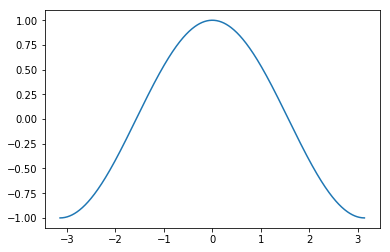

In [160]:
x = np.arange(-np.pi, np.pi, 0.01)
y = np.cos(x)

plt.plot(x, y);

##### ReLU (Rectified Linear Unit)

The most simple nonlinear function is called **ReLU** or rectified linear unit, and is defined as $\text{ReLU}(x) = \max(0, x)$.

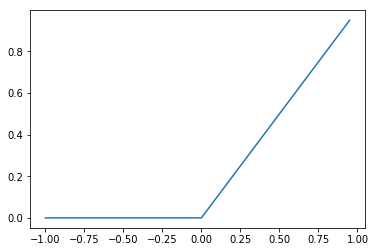

In [161]:
x_relu = np.arange(-1, 1, 0.05)
plt.plot(x_relu, np.maximum(x_relu, np.zeros(x_relu.shape)));

We will use ReLUs to approximate this function, with the model:

$$\hat{y}_1 = \sum_{i = 1}^N a_i \cdot \text{ReLU}(b_i + c_i \cdot x)$$

We'll contrast this model with another that can only use linear functions:

$$\hat{y}_2 = \sum_{i = 1}^N a_i \cdot b_i + c_i \cdot x$$

In [237]:
def train(num_relus=20, mode='nonlinear'):
    LEARNING_RATE = 0.01

    a = np.random.random(size=num_relus) - 0.5
    b = np.random.random(size=num_relus) - 0.5
    c = np.random.random(size=num_relus) - 0.5

    def L(y, y_hat):
        return (y - y_hat)**2

    def R(x):
        if mode == 'nonlinear':
            return np.maximum(0, b + c*x)
        else:
            return b + c*x

    def f(x):
        return np.dot(a, R(x))

    def backward(x, y):
        nonlocal a, b, c
        
        y_hat = f(x)
        dy_hat = -2*(y - y_hat)

        R_hat = R(x)

        dR = a

        da = R_hat
        if mode == 'nonlinear':
            db = np.zeros(num_relus)
            db[R_hat > 0] = 1
        else:
            db = np.ones(num_relus)

        dc = np.zeros(num_relus)
        if mode == 'nonlinear':
            dc[R_hat > 0] = x
        else:
            dc.fill(x)
            
        a -= LEARNING_RATE * dy_hat * R_hat
        b -= LEARNING_RATE * dy_hat * dR * db
        c -= LEARNING_RATE * dy_hat * dR * dc

    # SGD
    ITERATIONS = 1000

    for _ in range(ITERATIONS):
        i = np.random.choice(x.shape[0])
        x_i = x[i]
        y_i = y[i]
        y_hat = f(x_i)
        backward(x_i, y_i)
    
    return f

In [240]:
f_nonlinear = train(mode='nonlinear')
f_linear = train(mode='linear')

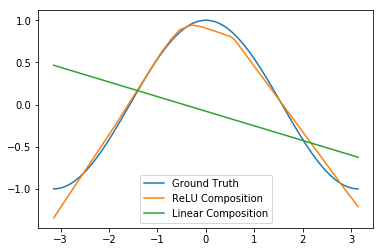

In [241]:
y_hat_nonlinear = np.zeros(y.shape)
y_hat_linear = np.zeros(y.shape)
for i, x_i in enumerate(x):
    y_hat_nonlinear[i] = f_nonlinear(x_i)
    y_hat_linear[i] = f_linear(x_i)
plt.plot(x, y, label='Ground Truth')
plt.plot(x, y_hat_nonlinear, label='ReLU Composition')
plt.plot(x, y_hat_linear, label='Linear Composition')
plt.legend();

As you can see, the nonlinear composition just blew the linear composition out of the water!

<a id='section1'></a>
## What are Neural Networks?
Neural networks derive their name from the neural network we have in our head, our brain. In a very highly simplified model, the brain is a collection of neurons that receives electrical input signals from dendrites, outputting electrical signals via a single axon. Each neuron sends signals along a single axon and connects with other dendrites. 

<img src= "IMAGES/neuron_connection.gif">


Neural networks attempt to model this by having artificial layers neurons that perform minor tasks, then communicate from layer to layer. The collection of neurons operate together to begin to understand the raw input in layers - in each layer, the neurons summarize the data a little bit further, until they finally arrive at a single label.
This sums up the feed forward neural network, which is what we'll be exploring today.

#### Understanding how a feed forward neural network can be divided into three essential parts.
1. The single neuron and activation functions.
2. Forward Propagation.
3. Learning


<a id='section1.1'></a>
## The Single Neuron

Every neural network is comprised of many neurons connected with weights. The neuron itself is the backbone of the network, and each neuron accomplishes the following tasks
1. Receives information through weights pointing to that neural multiplied by the neuron the weight originated from.
2. Applies the activation function denoted by f to the sum of the weights multiplied by the previous neuron.
3. Returns an result in the form of the outer layer.

<img src= "IMAGES/biological_neuron.jpeg">


The diagram above shows a single neuron taking in other neurons $x_0$, $x_1$ and $x_2$ with weights $w_0$, $w_1$ and $w_2$, respectively. The output from the neuron is the output axon. The function f is the Activation Function. The purpose of the activation function is to introduce non-linearity into the output of a neuron. This is necessary because using only linear functions to predict real world data is a poor decision. Greater accuracy requries neurons to learn nonlinear representations. We'll learn more about activation functions next.

<a id='section1.2'></a>
## An Introduction to Activation Functions
Consider each activation function in the neural network to be linear of the form$f^{(i)}(x)=a_ix+b_i$. Then if we compose many of these linear functions together, we would get some $f(x)=f^{(n)}(f^{(n-1)}(\ldots f^{(1)}(x)\ldots ))=ax+b$ for some $a,b$. Since the composition of multiple linear functions is always a linear function, we essentially will conduct linear regression. Without the inducement of nonlinearities, our model can only do as well as linear regression. So what activation functions can we use instead of linear functions?

There are many common activation functions.

$\textit{Sigmoid}$ is useful if you want only positive numbers. However, it has fallen out of popularity recently because it causes gradients to vanish. When a neruon's activation saturates close to 0 or 1, the gradient will be really close to 0. During backpropogation this causes the signal to be lost. Also, because it is not 0-centered, it has a greater chance for gradient updates to go far in either direction.
<img src = "IMAGES/sigmoid.png" style="width:300px;height:250px">
$\textit{Tanh}$ has many advantages over sigmoid since the activation function is centered at zero, and can output negative numbers. In practice, $\textit{tanh}$ is preferred over sigmoid, but it stil creates vanishing gradients problem when x becomes too large or too small.
<img src = "IMAGES/tanh.png" style="width:300px;height:250px">
$\textit{ReLU}$ Rectified Linear Unit is one of the most common activation functions used. It is simply the function $\max(0,x)$, essentially thresholding at zero.
<img src = "IMAGES/relu.png" style="width:300px;height:250px">

### Check for Understanding
>Why is our activation function non-linear?


<a id='section1.3'></a>
## Feedforward 
Most neural networks with the goal of classification follows the feedforward model. The feedforward model always contains three essential parts.
1. Inputs
2. Hidden Layers
3. Output (or result)

An example of a feedforward neural network is shown below.


<img src= "IMAGES/feedforward.png">



In the diagram of a neural network shown above, the circles represent neurons, and the arrows represent the communication, or weights, between neurons. All neurons must connect to all neurons in the next layer. These nodes are feed forward since the information propagates from the input on the left side through intermediate calculations to a final output layer.

#### Intuitively, a feedforward neural network can consist of three levels with corresponding neurons:
    
1.	**Input Layer**: The Input layer has is where $X_i$ from the previous example are inputted. The outputs from the Input layer are just the input $X_i$ and the bias. These are moved into the Hidden Layer. 
2.	**Hidden Layer** – The Hidden layers contain neurons that move numbers from the input neurons to the output neurons. They take in the inputs from the input layer. In the running example with car classification, the hidden layers can be items such as "number of seats" or "weight". The hidden layers represent the different steps it takes to classify a vehicle. The number of neurons in the hidden layers are determined by the user. There can be as many hidden layers as necessary depending on the problem.
3.	**Output Layer** – The neurons in the output layer are the results that the NN returns. 

#### Mathematically, a feedforward neural network can be explained below:

We are given $(X_i,y_i)$ pairs where $y\approx f^*(x)$ is an approximation of the example relationships between $X_i$'s and $y_i$'s.

These feed-forward models attempt to model $f^*(x)$ by composing multiple functions together, such as $f^*(x)=f^{(2)}(f^{(1)}(x))$ in the neural network above. Notice that $f^{(1)}(x)$ and $f^{(2)}(x)$ are the middle layer in the model, but it is never used except in intermediate states, thus it is known as a hidden layer.

Our goal in machine learning is to take a set of inputs $X$ and approximate some function $f^*(X)$ in order to calculate the Output Layer.

**Quick example**: Imagine if we were looking at cars parked down a street. Our goal is to identify whether the car is a SUV or a truck. Think about $X_i$ as being a picture of that specific car, and the corresponding $y_i$ would be the type of car.

Then, $f^*(x)$ would be the function determining what type of car it is. $f^{(1)}(x)$ could be "number of seats" and $f^{(2)}(x)$ could be "weight of car". Then, $f^*(x)=f^{(2)}(f^{(1)}(x))$ would use those two hidden layers to classify the cars.

<img src= "IMAGES/representation.JPG">


### Check for Understanding
>There is no bias in the diagram above. In the hidden layer, where would the bias point to? <br>
>What are the dimensions of $a_1$? <br>
>What are the dimensions of $y$?


<a id='section1.4'></a>
## How Neural Networks Learn
The general idea in machine learning is given a model and dataset, we would like to minimize the loss or error of the model as it compares to the actual labels of the data. In deep learning, this is acheived by tweaking the weights of the neural network as we incrementally train on the train data to predict the misclassified numbers better. This leads us to two major questions: $(1)$ what is the loss function of our model, and $(2)$ how do we update the weights of our model as we train it?

### Backpropagation
Backward Propagation, is one of the most popular ways in which a neural network can be trained. Backward Propagation uses training data that depicts the class of the instance as well as its elements.
Backward Propagation can be summarized as the method of guessing and checking.

Every time the algorithm is run, it guesses weights to assign to every neuron, then computing what it thinks the value is. Then it checks with the actual value to readjust weights and create a better classifier. The end goal for training a neural network is to assign the weights that will result in a correct classification.

### Detailed Car Example

Let’s explore an example. Let's say the cars on the road had the following statistics:

<img src= "IMAGES/car_table.JPG">

In the above graph, the first two columns provide description on the vehicle while the last column displayed the type of vehicle. 

Now given the data above and the particular instance below, what type of vehicle would you classify it as?

<img src= "IMAGES/cars_test.JPG">

We'll define the **training table** to be the **car statistics table** from above and the **test data** as the one particular instance above.

To make our solution easier to analyze, let's assign 1 to truck and 0 to SUV. Therefore, if the network returns a number close to 1, the vehicle is most likely a truck, and if a number close to 0 is returned, the vehicle is most likely a SUV.

### Step 1: Assign Weights

Take the figures below to be the neural network of our car classifying problem.

All weights in the network are randomly assigned. Let’s consider the red hidden layer node below. Assume the weights of the connections from the inputs to that node are w1, w2 and w3 (as shown).


<img src= "IMAGES/ANN_4.png">


The network takes the first row from the training table with input (with 5 seats, 5000 pounds, and 12.1 feet long, the desired probability is 1).

Input to the network = $[5, 5000, 12.1]$

Desired output from the network (target) = 1

The red node in consideration can be calculated as below (f is an activation function such as sigmoid):

red = $f (5*w1 + 5000*w2 + 12.1*w3 + bias)$


### Check for Understanding
>If the output y from the above example is 0.1, is that a good classification for the first car? <br>
>If the output y from inputting the test data is 0.4, is that a good classification for the test car?

### Step 2: Calculate Error
As a naive attempt at creating a loss function, we could have the loss be $0$ for correctly classifying the number and $1$ for incorrect classification. However, this is a bit naive because we lose a lot of information on what the correct answer is. A better loss function for classification is cross entropy loss. The formula may look a bit complex but the idea is simple. For a particular label $y$ and prediction distribution $\hat{y}$, our error is: $$z(\hat{y}) = -\sum_k y_k \log {\hat {y}}_k$$ where $y_k$ is an indicator of the correct label and $\hat{y}_k$ is our model's guess at how likely label $k$ is correct.

For example, if the current image is actually a $3$, then $y_3=1$ and $y_i=0$ for all $i\neq 3$. The $\hat y$ represents the probability distribution outputs from our model. Our model may classify the image as $20\%$ likely to be $1$, $30\%$ likely to be $2$, $50\%$ likely to be $3$, and $0%$ for the rest. The error would be the compute to be $z(\hat y) = -\log(0.5)$.

The key thing to notice about the cross-entropy loss is that the loss drastically increases as the probability for the correct label approaches zero. If we output a very low probability for the correct class, the logarithm approaches very large negative values, resulting in a large loss. On the other hand, if we output a very high probability close to $1$ for the correct class, the loss is almost zero since $\log 1 = 0$.

### Step 3: Updating Weights
After calculating the total error at the output nodes, our next step is being able to adjust the weights in the network. A popular method to use is gradient descent, which alters all weights in the network in order to minimize the total error. We will go into detail about how gradient descent works and how to write the code to do so later in the lecture.

<img src= "IMAGES/back.png">


If the algorithm has been executed correctly, inputting the first training point should now result in an accurate classification. The key take-away is that overall, for any point, the network should classify objects better since the weights have since been updated to minimize the error in prediction. 

The next step is to repeat steps 2 and 3 of the algorithm with all the other rows of the training dataset. Afterwards, the neural network is said to have learned all that data.

Then, the test data can be inputed to be classified by the neural network.

<img src="IMAGES/cost_function.png">

Fill out the algorithm in its entirety below:

### Summarized Backpropagation Algorithm:

1. Initially all the edge weights are _______ assigned.
2. For every input in the _______ dataset, the neural network runs and its output is observed.
3. This output is compared with the desired output that was given, and the error is “propagated” back to the previous layer.
4. This _______ is calculated and the weights are ______ accordingly.
5. This process is _______ until the output error is below a predetermined threshold that we decide.

This may seem extremely complicated, but coding this process is actually quite simple. We'll get into the how and why in the math below.

Once the above algorithm terminates, we have a “learned” NN which, we consider is ready to work with “new” inputs. This NN is said to have learned from several examples (labeled data) and from its mistakes (error propagation).

We now look at a specific example of a deep learning architecture through the MNIST Dataset, which is sort of the hello world example in deep learning.

<a id='section2'></a>
# Understanding the MNIST Dataset
Take a brief moment to read over the MNIST Wikipedia article.

The MNIST dataset consists of 70k images, 60k of which are considered the training set, with the remaining 10k for test. Each data entry $X_i$ in the MNIST dataset is a $28\times28$ pixel image of a single handwritten digit, and each is labeled with the associated digit between $0$ and $9$, denoted as $y_i$. Our goal is to design a model that learns a classification scheme from the 60k training images $\{X_i\}$ and their labels $\{y_i\}$, and then perform well in predicting which digit is represented in each test image.

### Check for Understanding
>Why is the MNIST dataset split into a training set and test set? <br>
>How many different classes (e.g. different kinds of labels) are present in the MNIST dataset? <br>
> Can you think of a particular pair of numbers that might be particularly difficult to differentiate, or prone to misclassification with each other?

## Acquiring the MNIST Dataset
The MNIST data actually comes packaged with keras, a package which we will be using later to implement our deep learning model, by default. So, let's install keras and take a look at the dataset.



In [37]:
from keras.datasets import mnist
num_classes = 10
# The data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


<a id='section2.1'></a>
## Structure of MNIST
We can verify that the data entries $X$ of train consist of $60,000$ images of $28\times28$ pixels in size. These entries come with labels $y_i$, one for each image $X_i$. A similar setup can be seen for the $10,000$ entries in test.

Each image $X_i$ is represented by a two-dimensional array (i.e. $28\times28$ matrix) of grayscale intensities ranging from $[0,255]$ to indicate the darkness of the ink at each pixel. $0$ represents a pixel that is completely white, and $255$ represents a pixel that is completely black.

### Check for understanding
> What does each $y_i$ represent, with respect to the corresponding $X_i$? What are the possible values for $y_i$?

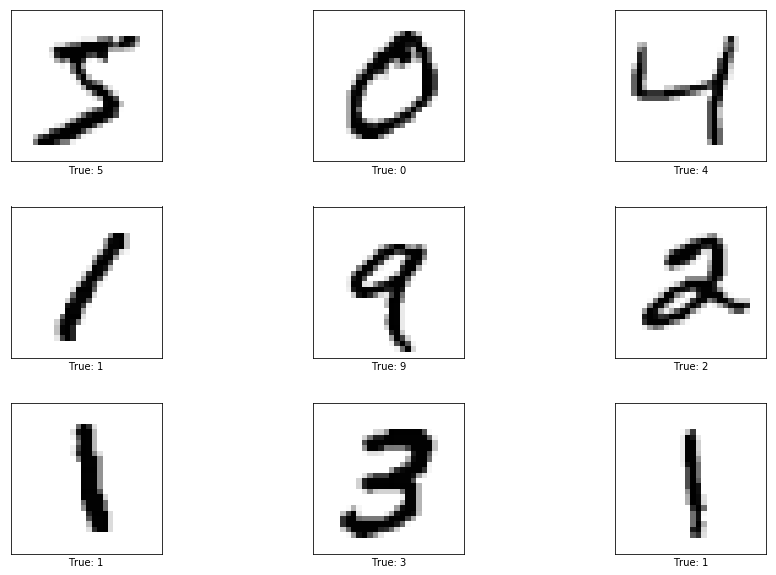

In [38]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape((28, 28)), cmap='binary')
        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show();
    
plot_images(X_train[0:9], y_train[0:9])

<a id='section2.2'></a>
## Data Preprocessing
The model we are working with requires flatten our two-dimensional arrays of $28\times28$ pixels into $28\times28=784$-dimensional vectors, and then change the units of the grayscale values to vary from $[0,1]$ rather than $[0,255]$ (the reason for this will be explained later). For our label vector $y$, we use to_categorical to one-hot-encode our labels - this command transforms our scalars $y_i \in [0,9]$ into binary class vectors $y'_i$.

In [39]:
# reshape 2d (28x28) image data into 1d vectors (28x28 = 784-d vectors)
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

In [40]:
import keras
# convert class labels into vectors. Ie 3 -> [0,0,0,1,0,0,0,0,0,0]
y_train_oe = keras.utils.to_categorical(y_train, num_classes)
y_test_oe = keras.utils.to_categorical(y_test, num_classes)

<a id='section3'></a>
# Intro to Keras

In [11]:
import keras
from keras.models import Sequential
from keras.layers import Dense

<a id='section3.1'></a>
## The Sequential Model
The Sequential Model is a Linear Stack of Layers. You can add layers with the .add() method

In [42]:
model = Sequential()

## Specifying the input shape
The model needs to know what input shape it should expect. For this reason, the first layer in a Sequential model (and only the first, because following layers can do automatic shape inference) needs to receive information about its input shape. 

In [43]:
model.add(Dense(30, activation='relu', input_shape=(784,)))
model.add(Dense(num_classes, activation='softmax'))

<img src="IMAGES/softmax.png">

<a id='section3.2'></a>
## Compilation
Before training a model, you need to configure the learning process, which is done via the compile method. It receives three arguments:

*   An optimizer. This could be the string identifier of an existing optimizer (such as rmsprop or adagrad), or an instance of the Optimizer class. 
*   A loss function. This is the objective that the model will try to minimize. It can be the string identifier of an existing loss function (such as categorical_crossentropy or mse), or it can be an objective function. See: losses.

*   A list of metrics. For any classification problem you will want to set this to metrics=['accuracy']. A metric could be the string identifier of an existing metric or a custom metric function.


In [44]:
# For a mean squared error regression problem
model.compile(optimizer='sgd', #How to Learn
              loss='mse') #What to Learn
# For a binary classification problem
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# For a multi-class classification problem
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

<a id='section3.3'></a>
## Training
Now that the model has been fully defined with loss-function and optimizer, we can train it. This function takes numpy-arrays and performs the given number of training epochs using the given batch-size. An epoch is one full use of the entire training-set. So for 10 epochs we would iterate randomly over the entire training-set 10 times

In [45]:
model.fit(x=X_train, y=y_train_oe, epochs=10, batch_size=128)

Epoch 1/10
60000/60000 [==============================] - 2s 25us/step - loss: 6.9325 - acc: 0.5619

<a id='section3.4'></a>
## Evaluation
Now that the model has been trained we can test its performance on the test-set. This also uses numpy-arrays as input.

In [46]:
result = model.evaluate(x=X_test, y=y_test_oe)
print("Evaluation error: %f \nTest accuracy: %f" % (result[0], result[1] * 100))

10000/10000 [==============================] - 0s 45us/step
Evaluation error: 1.034944 
Test accuracy: 93.150000


<a id='section3.5'></a>
## Prediction
We can also predict the classification for new images. We will just use some images from the test-set but you could load your own images into numpy arrays and use those instead.

In [47]:
y_pred = model.predict(x=X_test)

Then we convert the predicted class-numbers from One-Hot encoded arrays to integers.

In [48]:
cls_pred = np.argmax(y_pred, axis=1)
print(cls_pred[:5])

[7 2 1 0 4]


<a id='section3.6'></a>
## Examples of Mis-Classified Images
We can plot some examples of mis-classified images from the test-set.

In [49]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape((28, 28)), cmap='binary')
        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show();

In [50]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for all images in the test-set.
    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != y_test)
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = X_test[incorrect]
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    # Get the true classes for those images.
    cls_true = y_test[incorrect]
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

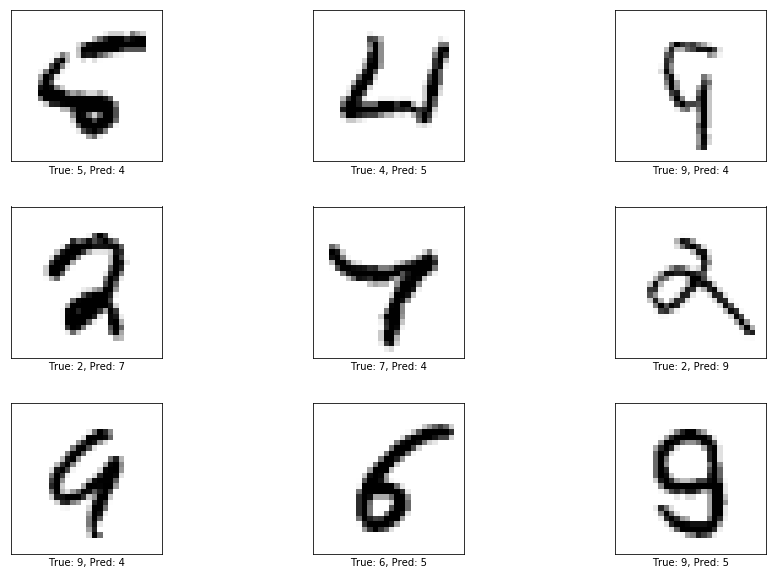

In [51]:
plot_example_errors(cls_pred)

### Sources Cited
https://ujjwalkarn.me/2016/08/09/quick-intro-neural-networks/

https://becominghuman.ai/deep-learning-made-easy-with-deep-cognition-403fbe445351?gi=306188a6ff43

http://www.saedsayad.com/artificial_neural_network.htm

https://www.neuraldesigner.com/blog/perceptron-the-main-component-of-neural-networks

https://www.researchgate.net/figure/Examples-of-2s-in-the-MNIST-database-first-100-examples-Note-the-very-diverse_fig1_2540340

# Regression (Housing Dataset)

<a id='section4'></a>
## Homework: Create your own neural network for the house price dataset
### Goal:
Create a model that achieves a test error of less than 30,000 using the root mean squared error metric
### Questions to Consider:
* How do you extract numpy arrays from dataframes?
* What loss function do we use for regression tasks? 
* What should the last layer look like? 
* How do you evalate your model on the test set?

### Experiment with the results of:
* Different optimizers (sgd, rmsprop, adam)
* Different number of hidden layers / number of neurons in each hidden layer
* Different activation functions (sigmoid, tanh, relu)
* Different number of features
* Reguarization methods (Droput) if you think your model is overfitting

In [4]:
# Import cleaned dataset
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv("DATA/train_cleaned.csv")
df = df[df.columns[2:]]
one_hot = pd.get_dummies(df)

In [5]:
#Split into train test
train, test = train_test_split(one_hot, test_size=0.2)

In [6]:
# Get Y train and Y test
Y_train = train["SalePrice"].values
train.drop("SalePrice", axis =1, inplace=True)
Y_test = test["SalePrice"].values
test.drop("SalePrice", axis =1, inplace=True)

/Users/sparajuli/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/sparajuli/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
#Function that returns root mean squared error
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

/Users/sparajuli/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/sparajuli/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [8]:
# Create model here!